In [1]:
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Cargar datos.

Se van a usar wavelength, flujo corregido por blaze y flujo corregido por blaze + continuo (indices 0, 3 y 5).

In [2]:
#print fits.getheader('/Volumes/Felipe/HD1397.fits')
#print fits.getheader('/Volumes/Felipe/goceres/outproc/HD-22049_20070829_UT08:46:50.682_sp.fits')

ace_data = fits.getdata('/Volumes/Felipe/HD1397.fits')
eps_data = fits.getdata('/Volumes/Felipe/goceres/outproc/HD-22049_20070829_UT08:46:50.682_sp.fits')

aflux = np.concatenate(ace_data[5,:,:])
abflu = np.concatenate(ace_data[3,:,:])
amask = aflux != 0

aflux = aflux[amask]
abflu = abflu[amask]
awave = np.concatenate(ace_data[0,:,:])[amask]

aorde = np.argsort(awave)
aflux = aflux[aorde]
abflu = abflu[aorde]
awave = awave[aorde]



eflux = np.concatenate(eps_data[5,:,:])
ebflu = np.concatenate(eps_data[3,:,:])
emask = eflux != 0

eflux = eflux[emask]
ebflu = ebflu[emask]
ewave = np.concatenate(eps_data[0,:,:])[emask]

eorde = np.argsort(ewave)
eflux = eflux[eorde]
ebflu = ebflu[eorde]
ewave = ewave[eorde]

Copié la Tabla 2 de Wise et al.

Las longitudes de onda que entregan están medidas en el aire y hay que transformarlas al vacío. En sentido contrario es mucho más confiable pero encontré una función que aproxima bastante bien (después se verá que encuentra las líneas)

In [3]:
def convert(lam):
    s = 10**4 / lam
    a = (1 + 0.00008336624212083 + 0.02408926869968 / (130.1065924522 - s**2)) + (0.0001599740894897 / (38.92568793293 - s**2))
    return lam*a

dlines = pd.read_csv('lines.csv')
print dlines

      tau   lambda  eps eri slope  alpha cen B slope  \
0   0.753  5110.42          0.212              0.137   
1   0.733  4375.94          0.205              0.140   
2   0.710  4427.32          0.185              0.130   
3   0.702  4461.66          0.176              0.110   
4   0.694  5012.08          0.155              0.092   
5   0.685  5269.54          0.102              0.110   
6   0.676  5397.13          0.142              0.118   
7   0.673  5429.70          0.129              0.132   
8   0.667  5506.78          0.132              0.114   
9   0.667  4571.10          0.147              0.073   
10  0.661  6562.81          0.149              0.444   
11  0.645  5051.64          0.134              0.092   
12  0.643  5371.50          0.099              0.120   
13  0.639  5405.78          0.105              0.121   
14  0.634  5501.47          0.127              0.082   
15  0.631  5227.19          0.097              0.089   
16  0.625  5107.45          0.133              0

Encontrar todas las líneas de la Tabla. Se convierte una por una y se gráfica donde cae. Notar que sin la transformación no caen en cualquier otro lado (de ahí inferí que estaban medidas en el aire).

La conversión es primero de aire a vacío y luego se corrige por velocidad, con la variable delta que depende de la RV medida de cada espectro (por lo que esto debería calcularse al final de todo el proceso de CERES).

Notar también que hay casos que caen cerca de bordes de órdenes. En esta parte no es tan crítico salvo el segundo caso, donde pareciera que las longitudes de onda no coinciden del todo (hay una línea prominente a la derecha pasados los 4380 A).

En el paper me parece que pesan de alguna manera para juntar los órdenes. Lo otro sería ver si es un solo orden que esta muy cerca del borde y me imagino no considerar ese. En las líneas que vienen después se ve que hay más problemas respecto a esto.

/Users/felipe/miniconda3/envs/27/lib/python2.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


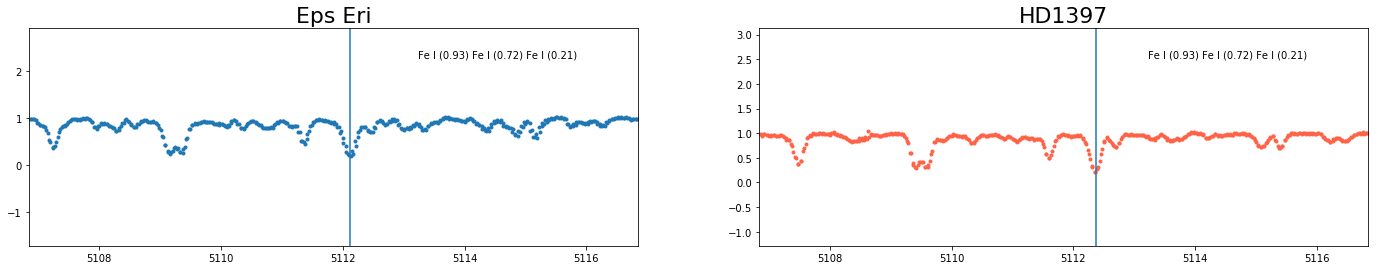

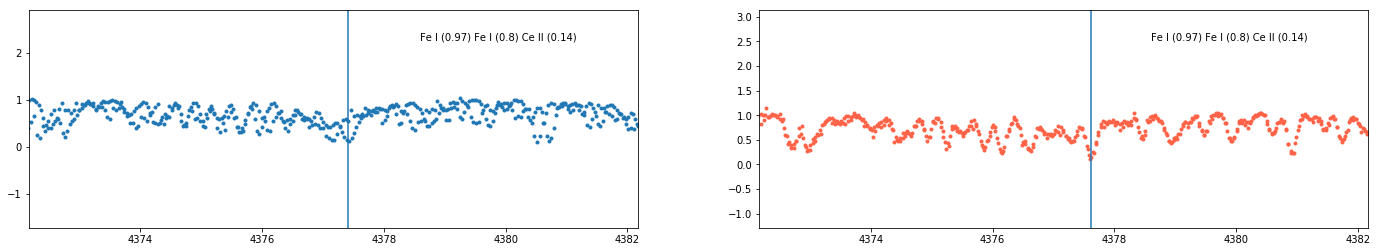

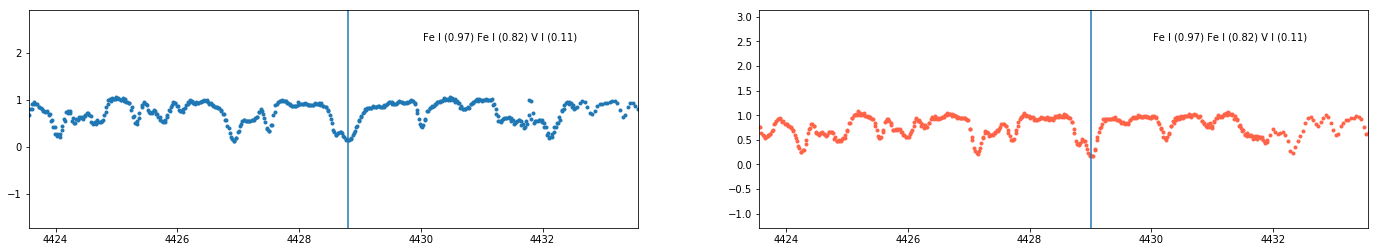

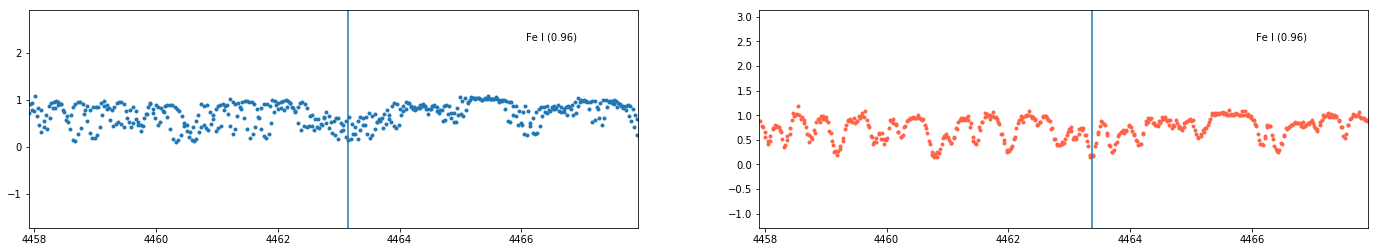

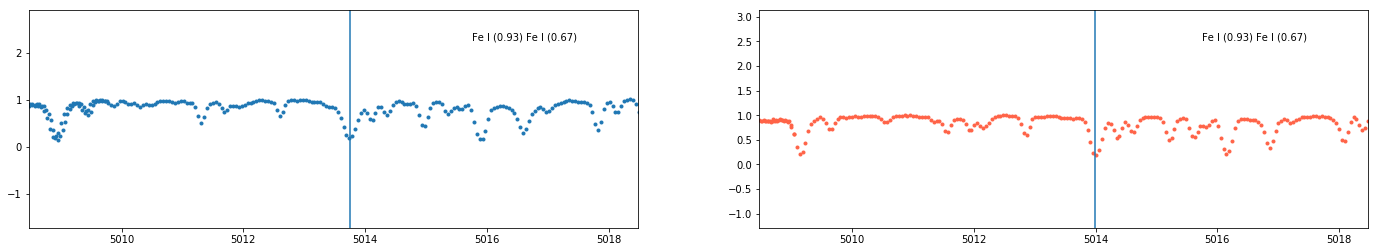

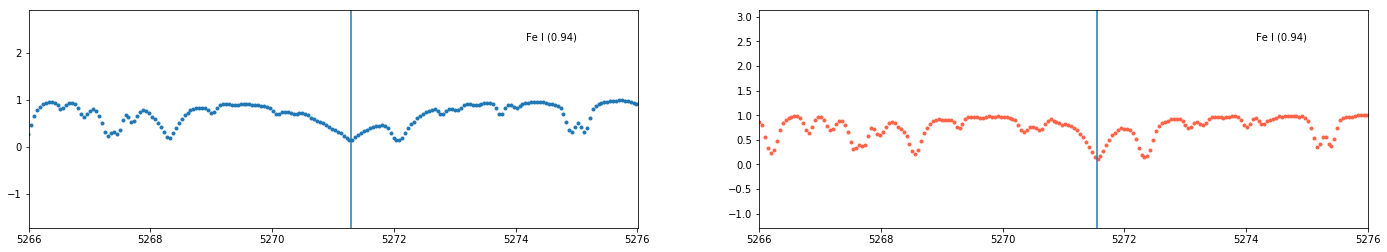

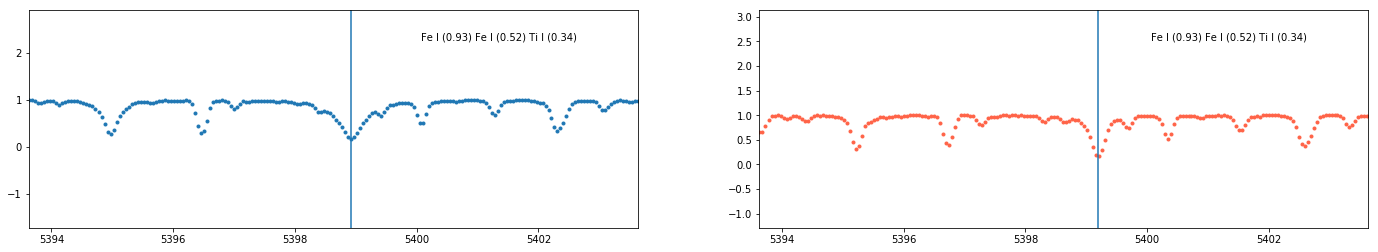

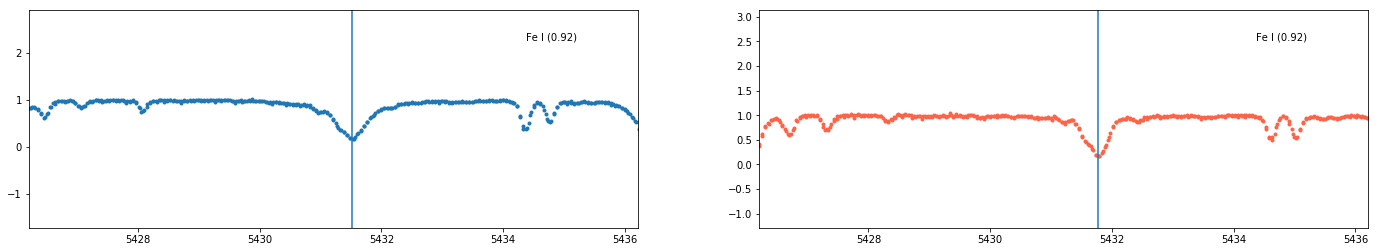

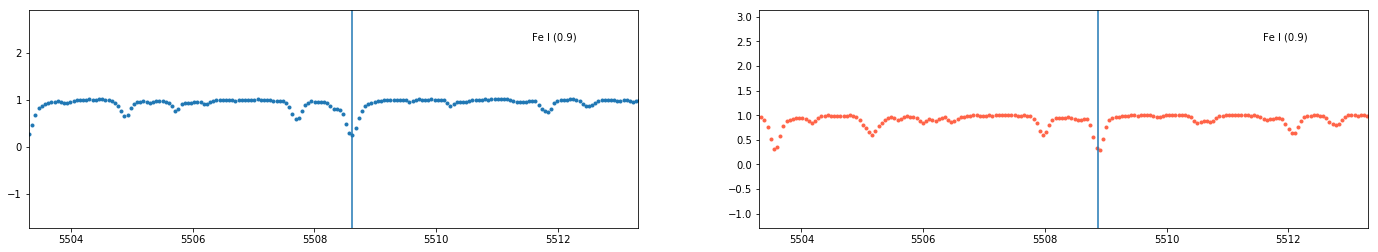

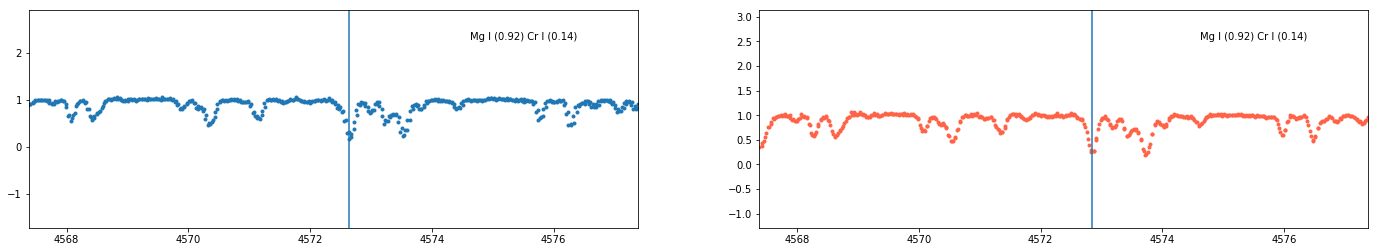

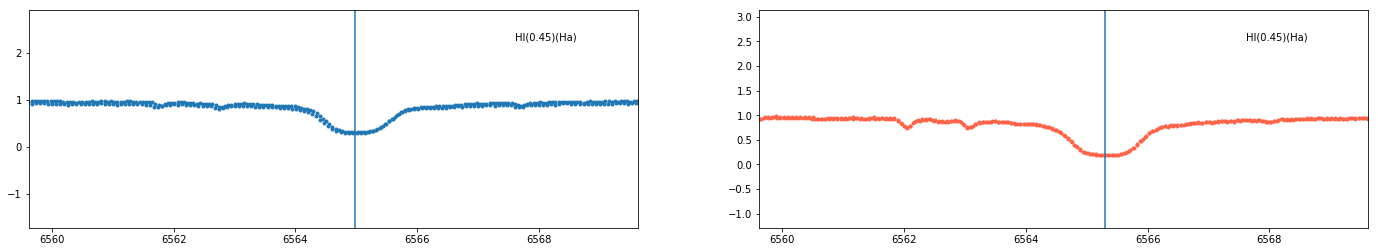

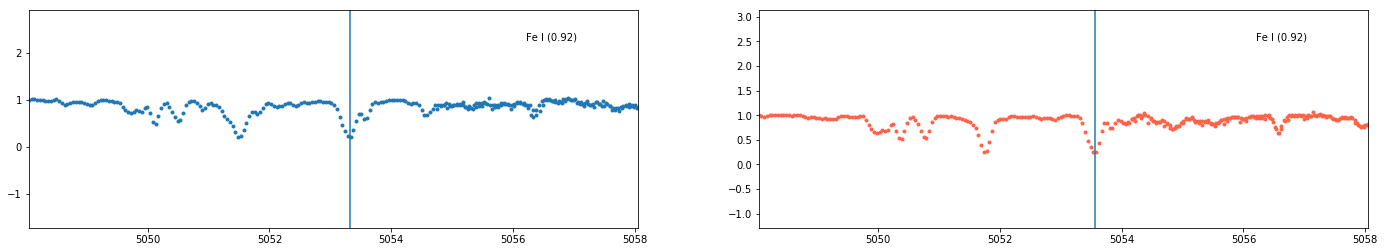

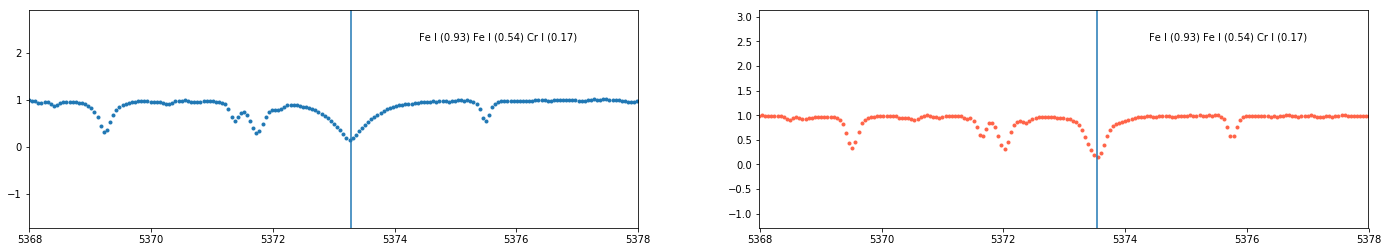

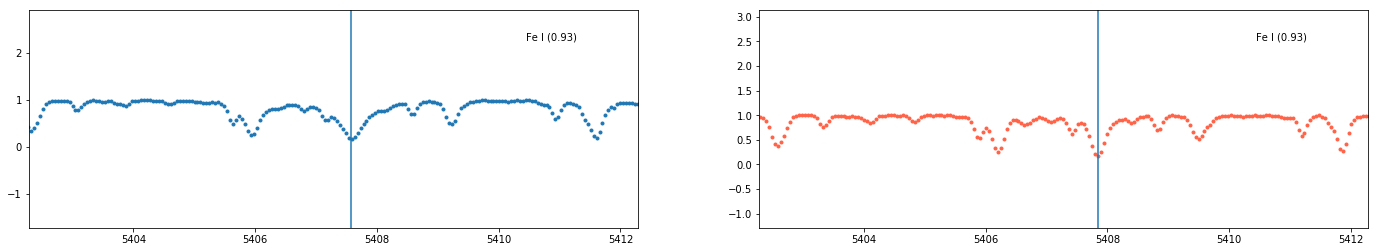

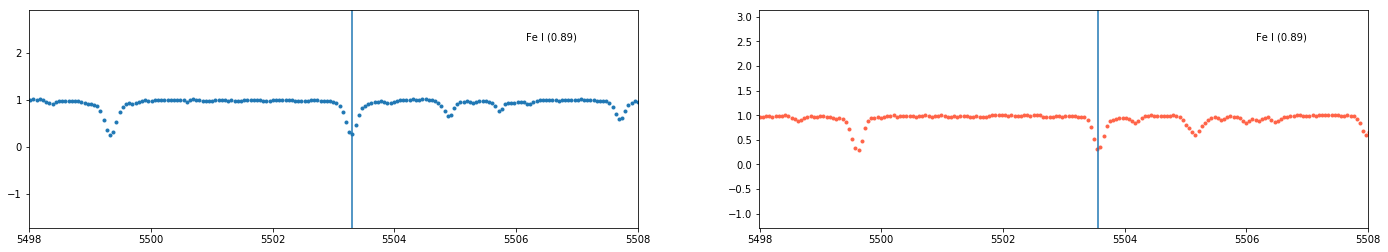

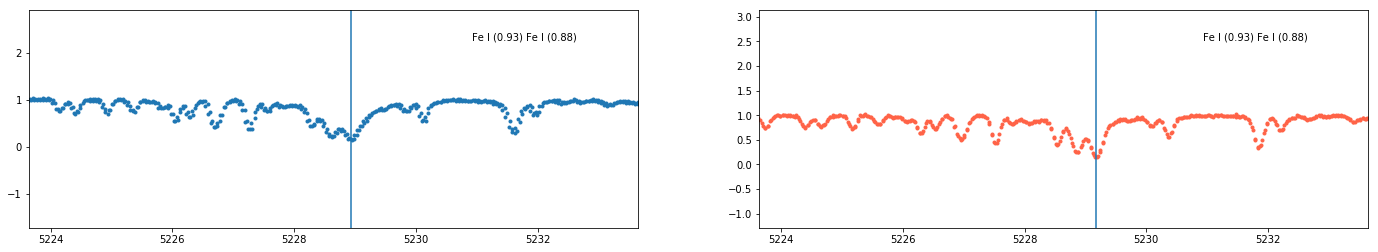

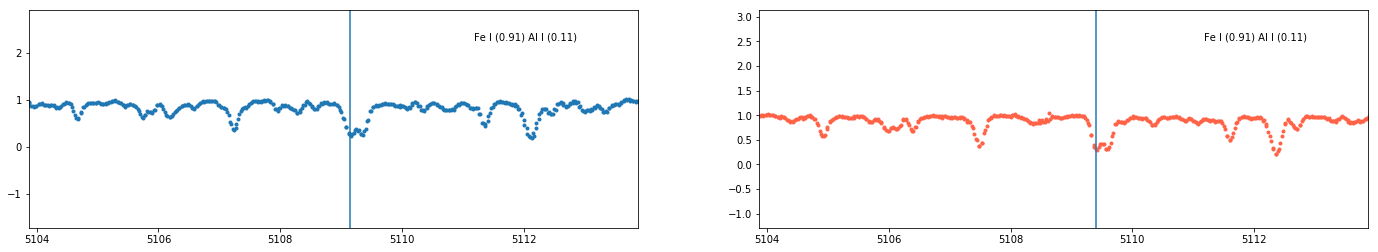

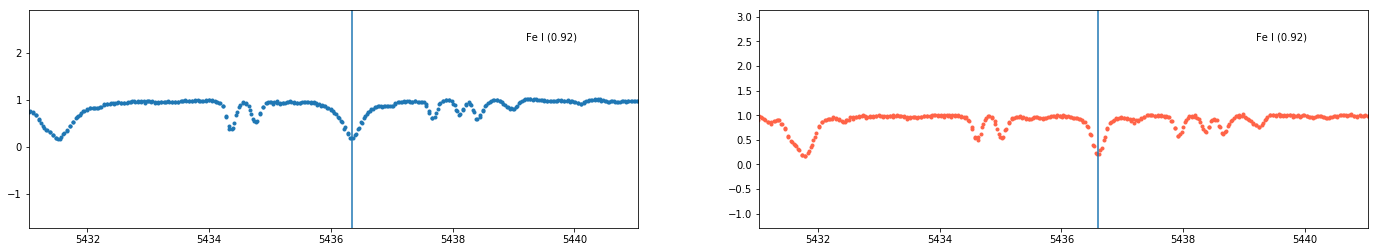

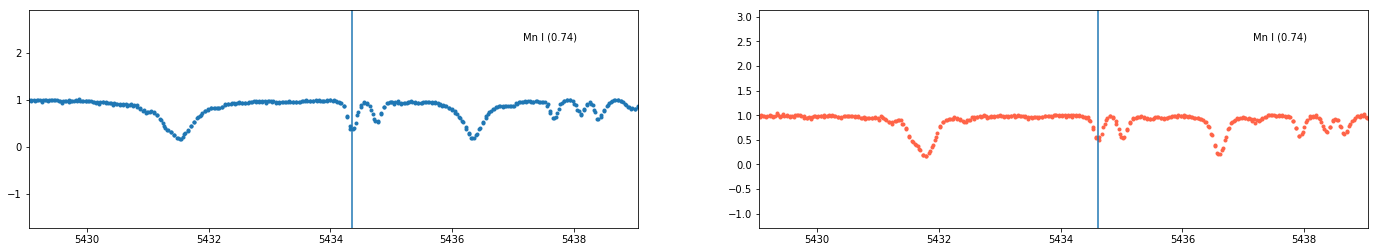

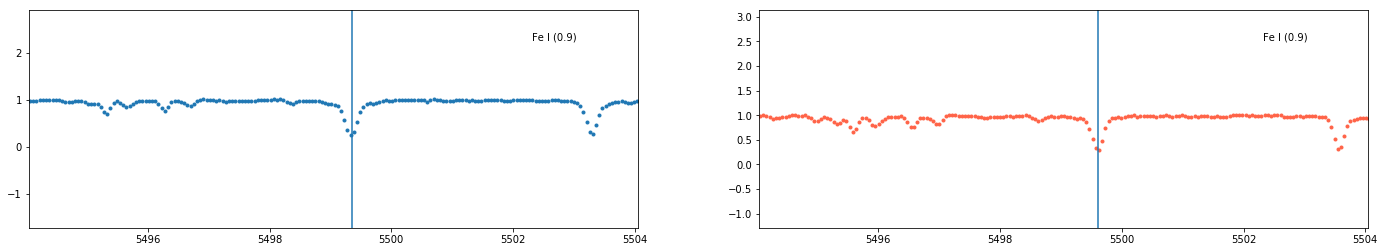

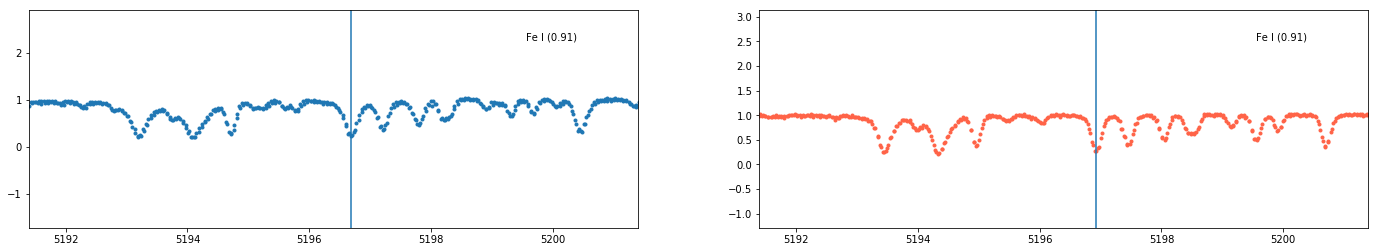

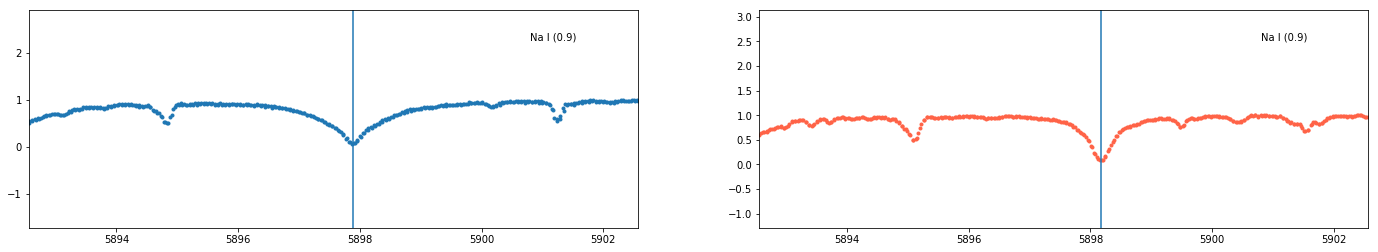

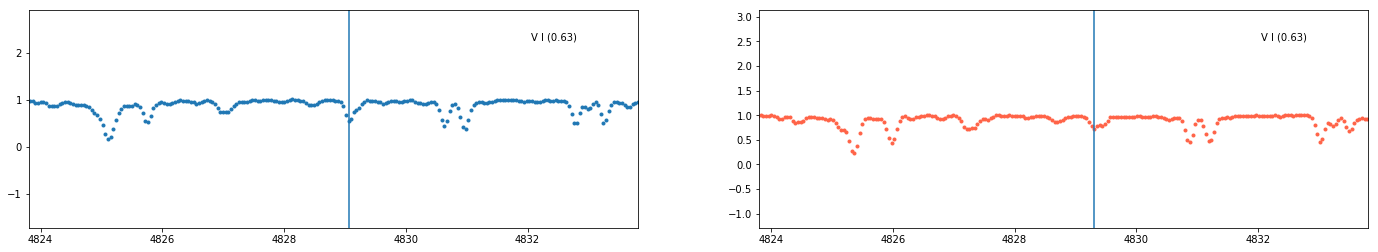

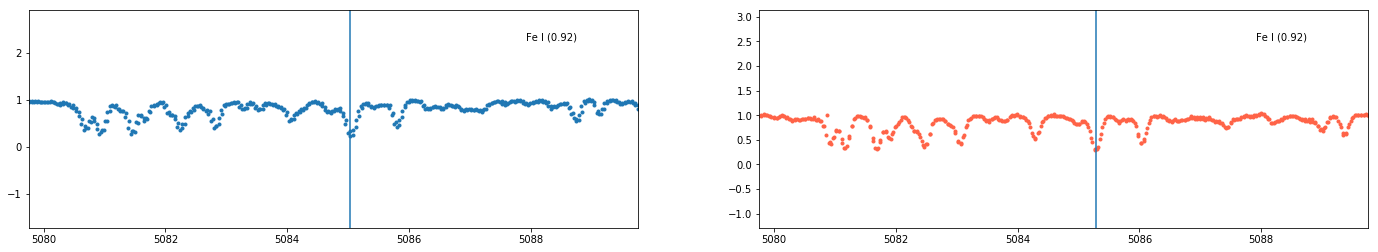

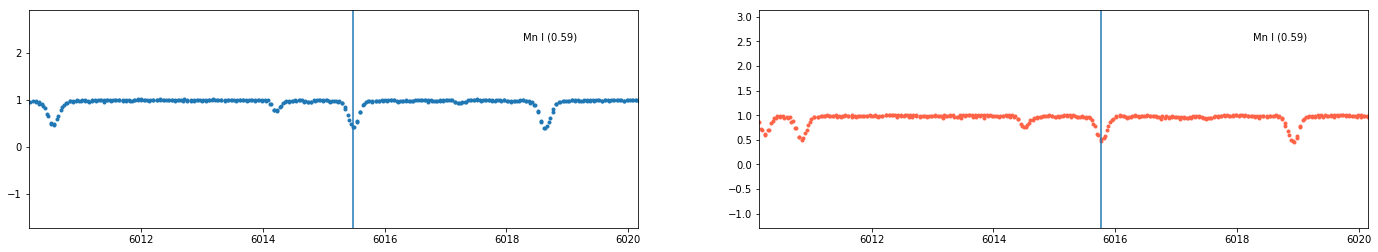

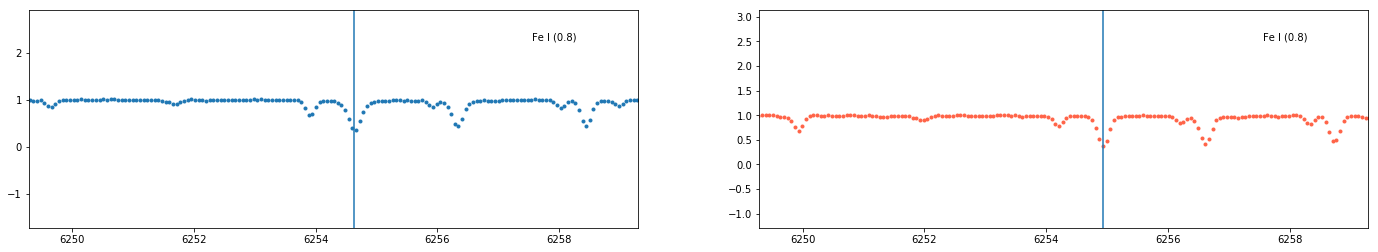

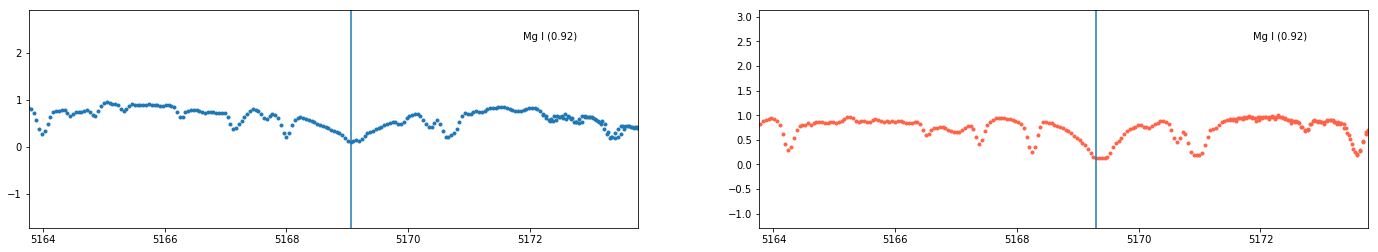

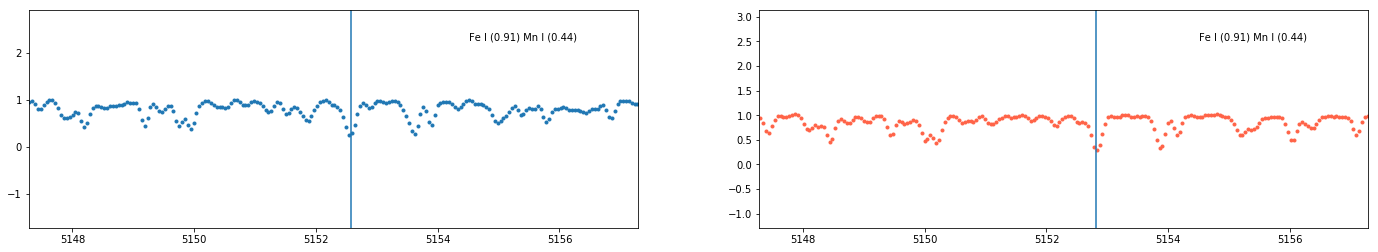

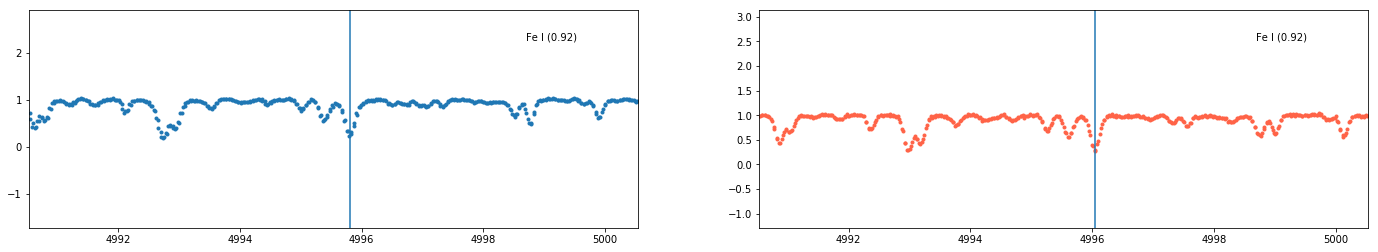

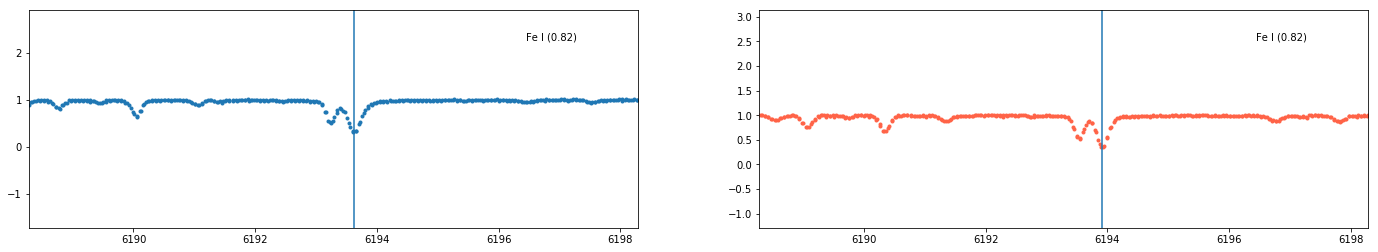

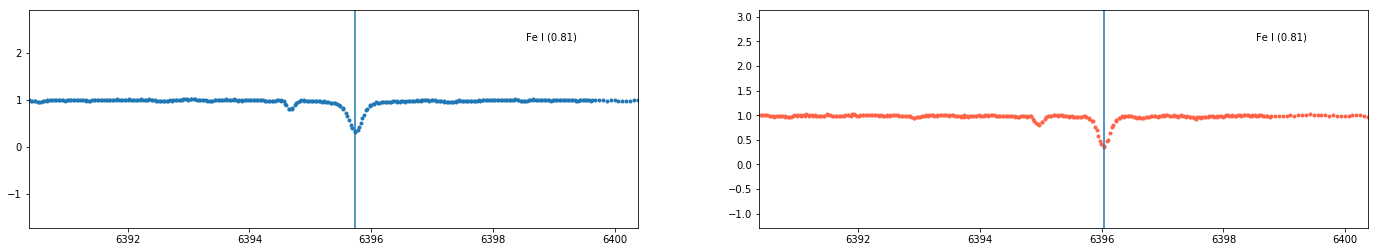

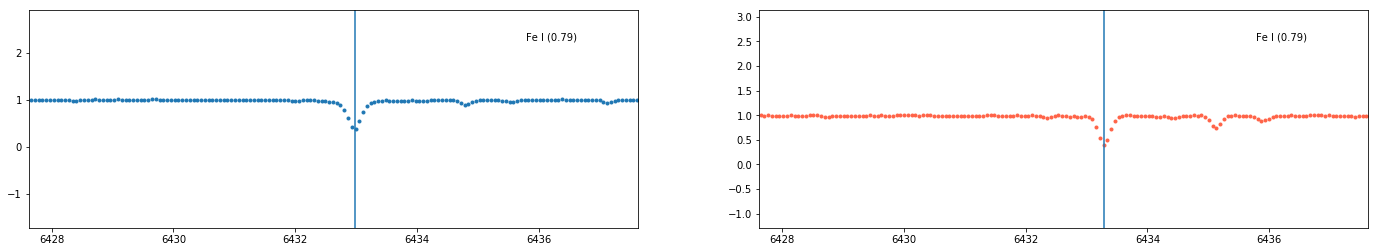

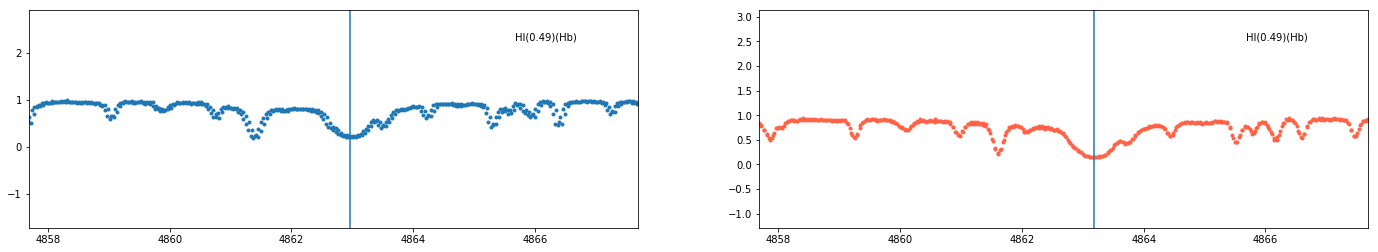

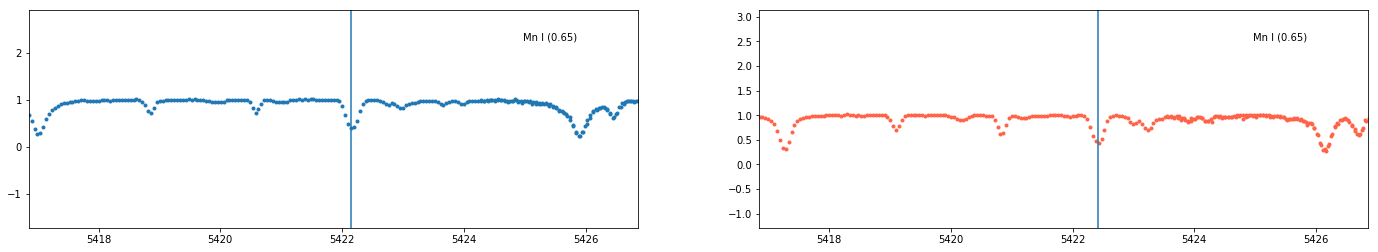

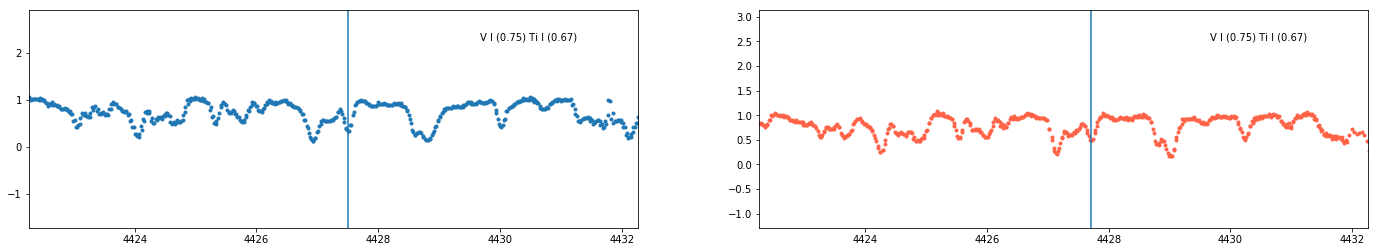

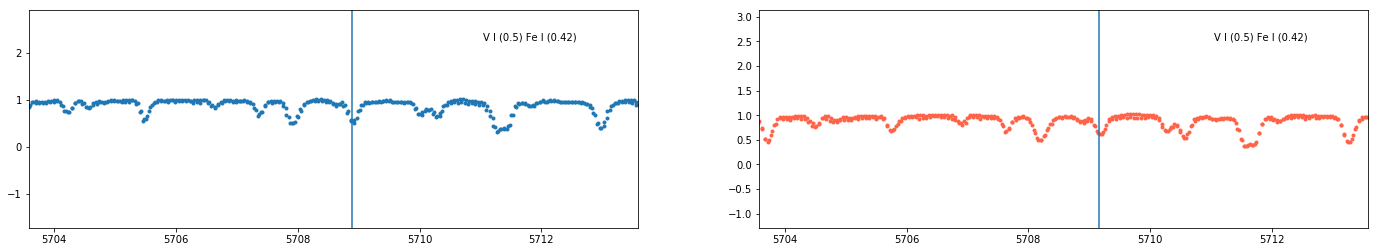

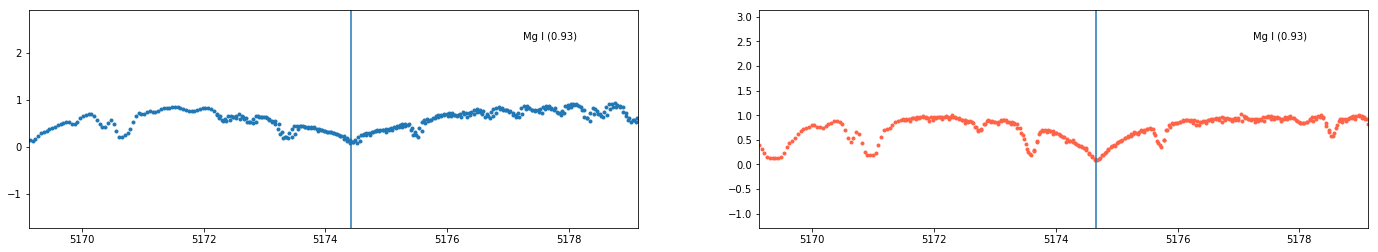

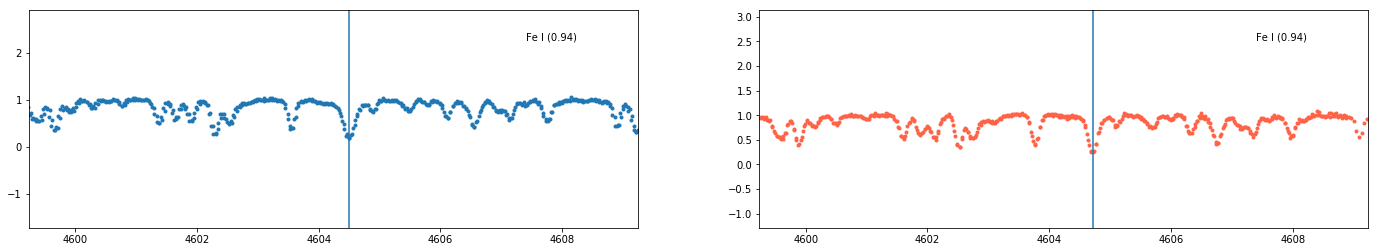

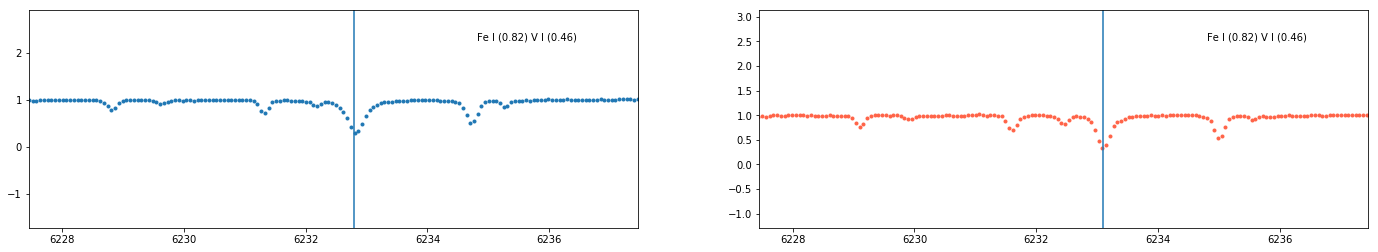

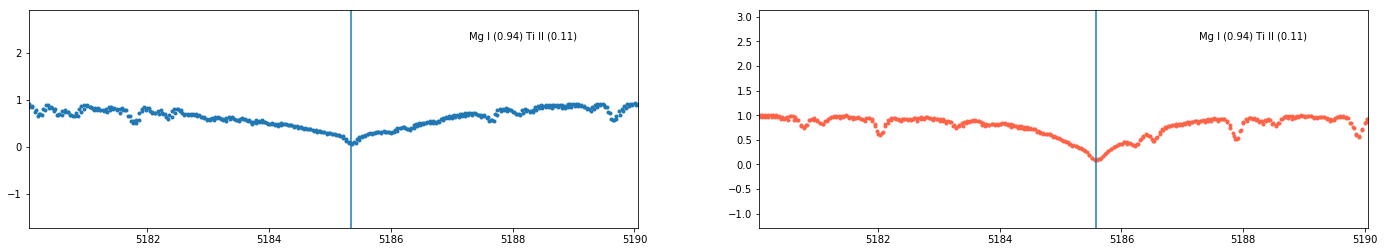

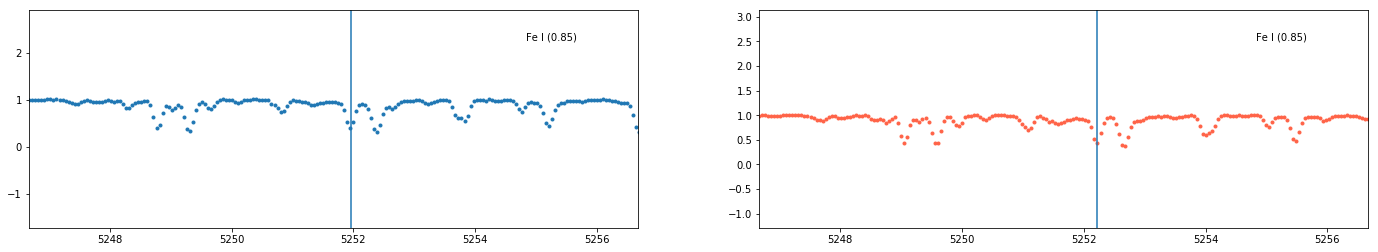

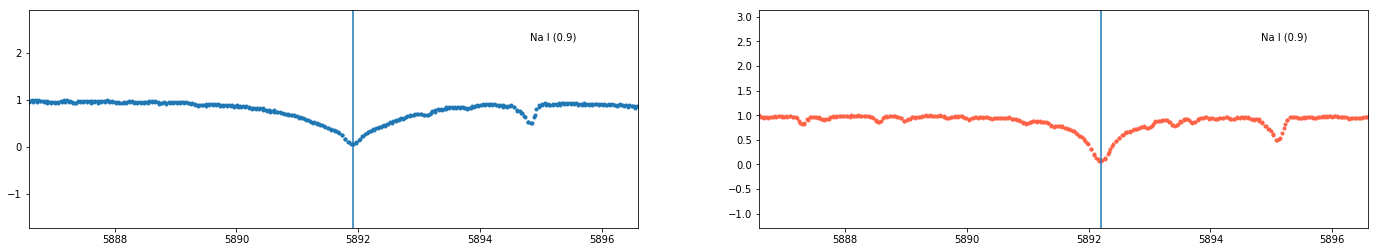

In [4]:
adelta = 30.7871 / 3e5
edelta = 16.5140 / 3e5

for i in xrange(len(dlines)):
    l = dlines['lambda'][i]
    w = dlines['species'][i]
    
    lamm  = convert(l)

    fig, ax = plt.subplots(figsize=[12*2,4], ncols=2)
    
    ax[0].plot(ewave, eflux, '.')
    ax[0].set_xlim(lamm-5, lamm+5)
    ax[0].axvline(lamm*(1 + edelta))
    ax[0].text(0.9, 0.9, w, transform=ax[0].transAxes, ha='right', va='top')
    
    
    ax[1].plot(awave, aflux, '.', c='tomato')
    ax[1].set_xlim(lamm-5, lamm+5)
    ax[1].axvline(lamm*(1 + adelta))
    ax[1].text(0.9, 0.9, w, transform=ax[1].transAxes, ha='right', va='top')
    
    if i==0:
        ax[0].set_title('Eps Eri', fontsize=22)
        ax[1].set_title('HD1397', fontsize=22)

Hay que medir el indice S del Monte Wilson (eje x para verificar si hay correlación con las líneas de actividad).

Este está definido por una razón entre flujos

$S = \alpha \frac{H+K}{R+V}$

Para obtenerlo se sigue el mismo procedimiento de Lovis et al 2011a:

* $\alpha$ es una constante que dicen se fija en 2.3 o 2.4 (Duncan et al 2011) o bien puede ser calibrada según Baliunas et al 1995.
* Las bandas corresponden a las líneas H y K de Ca II, centradas en 3968.470 A y 3933.664 A, respectivamente. Se espera una forma más o menos triangular con un FWHM de 1.09 A.
* R y V se definen como ventanas de 20 A centradas en 4001.070 A y 3901.070 A, respectivamente.

Se plotea ahora cómo se ven estas líneas con su respectiva ventana dada por el FWHM. Acá puede (aunque en este caso parrticular pareciera que no tanto) que haya problemas, dado que también se intersectan dos órdenes. En epsilon Eri se ven bastante bien, pero en alpha Cen B la línea se ve "doble", como con una hendidura en el centro. Voy a rehacer esto con el archivo de alpha cen B.

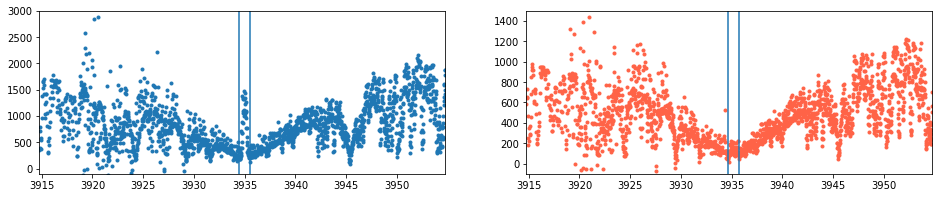

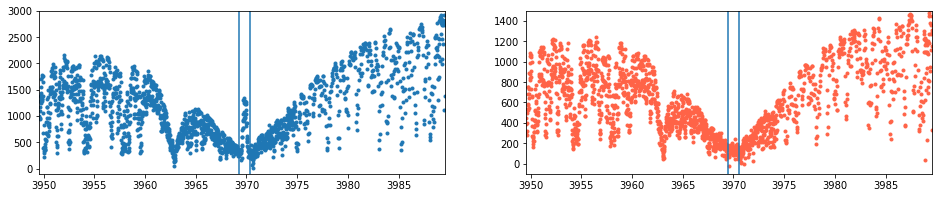

In [5]:
CaK = [3933.664, 3968.470]

for l in CaK: 
    lamm  = convert(l)

    fig, ax = plt.subplots(figsize=[16,3], ncols=2)
    
    ax[0].plot(ewave, ebflu, '.')
    ax[0].set_xlim(lamm-20, lamm+20)
    ax[0].set_ylim(-100,3000)
    ax[0].axvline(lamm*(1 + edelta) - 1.09/2.)
    ax[0].axvline(lamm*(1 + edelta) + 1.09/2.)
    
    ax[1].plot(awave, abflu, '.', c='tomato')
    ax[1].set_xlim(lamm-20, lamm+20)
    ax[1].set_ylim(-100,1500)
    ax[1].axvline(lamm*(1 + adelta) - 1.09/2.)
    ax[1].axvline(lamm*(1 + adelta) + 1.09/2.)

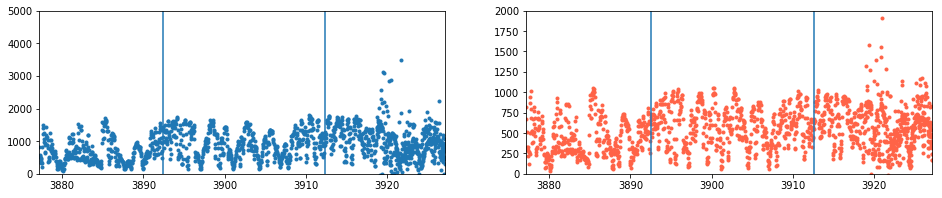

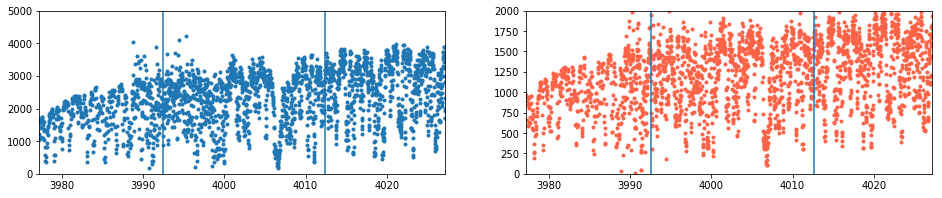

In [6]:
bands = [3901.070, 4001.070]

for l in bands: 
    lamm  = convert(l)

    fig, ax = plt.subplots(figsize=[16,3], ncols=2)
    
    ax[0].plot(ewave, ebflu, '.')
    ax[0].set_xlim(lamm-25, lamm+25)
    ax[0].set_ylim(0,5000)
    ax[0].axvline(lamm*(1 + edelta) - 10)
    ax[0].axvline(lamm*(1 + edelta) + 10)
    
    ax[1].plot(awave, abflu, '.', c='tomato')
    ax[1].set_xlim(lamm-25, lamm+25)
    ax[1].set_ylim(0,2000)
    ax[1].axvline(lamm*(1 + adelta) - 10)
    ax[1].axvline(lamm*(1 + adelta) + 10)

Hay otras consideraciones:
* The Mt Wilson spectrophotometer is designed in such a waythat  a  rapidly  rotating  slit  mask  sequentially  observes  thefour different channels at high frequency, and  **exposes the H and K channels 8 times longer than the continuum pass-bands**
* When working with ’normal’ spectrographs like HARPS, wewill then get 8 times less flux in the H and K passbands than the Mt Wilson spectrophotometer. To be on the Mt Wilson S-index scale, we have to multiply the H and K fluxes by $\alpha$ and then by 8


Finalmente, para medir esto de forma más fácil, notan que si expresamos $S$ en función del flujo promedio en un intervalo de longitud de onda $\overline X = X / \Delta\lambda_X $,

$S = \alpha \cdot 8 \frac{\Delta\lambda_{HK}}{\Delta\lambda_{RV}} \frac{\overline H + \overline K}{\overline R + \overline V}$

Pero,

$\alpha \cdot 8 \cdot \frac{\Delta\lambda_{HK}}{\Delta\lambda_{RV}} \approx 1$

Así que en buena aproximación

$S = \frac{\overline H + \overline K}{\overline R + \overline V}$

En la celda de abajo se verifica que esta aproximación es buena y que el factor es efectivamente 1 para $\alpha = 2.3$

In [7]:
aVmask = (awave > (convert(3901.070) - 10)) & (awave < (convert(3901.070) + 10))
aVflux = abflu[aVmask]
aVwave = awave[aVmask]
aVmean = np.mean(aVflux)
print 'V mean (HD) = ', aVmean * 20.
print 'V inte (HD) = ', np.trapz(aVflux, x=aVwave)
eVmask = (ewave > (convert(3901.070) - 10)) & (ewave < (convert(3901.070) + 10))
eVflux = ebflu[eVmask]
eVwave = ewave[eVmask]
eVmean = np.mean(eVflux)
print 'V mean (EE) = ', eVmean * 20.
print 'V inte (EE) = ', np.trapz(eVflux, x=eVwave)
print

aRmask = (awave > (convert(4001.070) - 10)) & (awave < (convert(4001.070) + 10))
aRflux = abflu[aRmask]
aRwave = awave[aRmask]
aRmean = np.mean(aRflux)
print 'R mean (HD) = ', aRmean * 20.
print 'R inte (HD) = ', np.trapz(aRflux, x=aRwave)

eRmask = (ewave > (convert(4001.070) - 10)) & (ewave < (convert(4001.070) + 10))
eRflux = ebflu[eRmask]
eRwave = ewave[eRmask]
eRmean = np.mean(eRflux)
print 'R mean (EE) = ', eRmean * 20.
print 'R inte (EE) = ', np.trapz(eRflux, x=eRwave)


alpha = 2.3
fact  = 8 * 1.09 / 20.
print '\nFactor = ', alpha*fact

V mean (HD) =  11725.8602231
V inte (HD) =  11717.1121499
V mean (EE) =  18683.0318882
V inte (EE) =  18683.8400522

R mean (HD) =  24103.9623448
R inte (HD) =  23980.302584
R mean (EE) =  45561.8114753
R inte (EE) =  45343.2180709

Factor =  1.0028


La función calcula el índice S, para una determinada velocidad. Convierto (tanto vacío como por Doppler shift) solo la línea central y dejo la ventana del mismo tamaño, pues no esperaría mucha variación (serían unas pocas líneas más sino).

In [8]:
def S_index(wave, flux, vel):
    '''
    Mt Wilson S-Index (Lovis 2011a)
    '''
    
    delta = vel / 3e5 #Doppler shift
    
    alpha = 2.3
    fact  = 8 * 1.09 / 20. #alpha*fact is ~1
    
    #Convert each line wavelength to vacuum
    Hline = convert(3968.470)*(1 + delta)
    Kline = convert(3933.664)*(1 + delta)
    Rline = convert(4001.070)*(1 + delta)
    Vline = convert(3901.070)*(1 + delta)
    
    #Masks for each line
    Hmask = np.abs(wave - Hline) <= 1.09/2.0
    Kmask = np.abs(wave - Kline) <= 1.09/2.0
    Rmask = np.abs(wave - Rline) <= 10.
    Vmask = np.abs(wave - Vline) <= 10.
    
    #Means
    Hmean = np.nanmean(flux[Hmask])
    Kmean = np.nanmean(flux[Kmask])
    Rmean = np.nanmean(flux[Rmask])
    Vmean = np.nanmean(flux[Vmask])
    
    ratio = (Hmean + Kmean) / (Rmean + Vmean)
    return fact*ratio

Este valor al menos está dentro del rango de ~0.15 a ~0.20 de la Figura 5 del paper de Wise et al

In [9]:
print S_index(awave, abflu, 30.7871 / 3e5)
print S_index(ewave, ebflu, 16.5140 / 3e5)

0.064651651281
0.175349214876


Queda pendiente calibrar el valor de S.

"[...] HARPS S index will already be very close to the Mt Wilson scale, so that in principle no further calibration should be needed. However, at least two aspects make it still necessary: potential scattered light in the Mt Wilson spectrophotometer and/or HARPS, and the exact value of the calibration constant $\alpha$. In any case, a simple linear calibration between the HARPS and Mt Wilson systems should be sufficient"

Lo que se hace es buscar estrellas observadas por ambos instrumentos y calcular sus índices S. Estas estrellas deben tener poca variabilidad intrínseca (rotación, ciclo magnético). Hay una tabla de las que utilizaron. Hecho esto se realiza un ajuste lineal. Ellos obtienen por ejemplo para HARPS:

$S_{MW} = 1.111\cdot S_{HARPS} + 0.0153$

Todo esto del índice S es porque este va en el eje X. En el eje Y (ahora usando el espectro normalizado por continuo, ie plano y valores entre 0 y 1) van los indicadores que sugieren:
* Line core flux: Mínimo de la línea
* Half-depth range: Ancho de la línea en la mitad del flujo
* Center of mass: $\int \lambda (F_{hd} - S) d\lambda / \int (F_{hd}-S)d\lambda$ ($F_{hd}$ es el half-depth flux y $S$ el valor del flujo según el ajuste con el spline

De los tres el más robusto encontraron que es el primero (y quizás el más fácil de calcular, aunque los 3 deberían ser sencillos y rápidos).

Para esta etapa se interpola mediante un spline cúbico el espectro, por lo que encontrar por ejemplo el mínimo debería ser trivial, conociendo las derivadas y que las longitudes de onda previstas son un muy buen guess como se vio en los gráficos, donde las líneas caen siempre en el centro de forma bien precisa.

El único problema detectado hasta el momento en esta parte, es que el spline no ajusta bien cuando se intersectan dos órdenes, ya que se manda unos saltos gigantescos (tipo líneas de emisión) por la pequeña diferencia en flujo que hay entre un punto de un órden y el siguiente del otro. La implicancia es que no se puede simplemente concatenar todos los órdenes y hay que priorizar o pesar de alguna buena forma donde se unen.

Para un solo orden:

(0, 1.5)

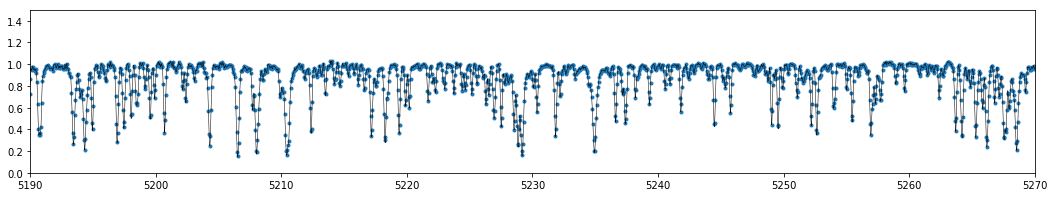

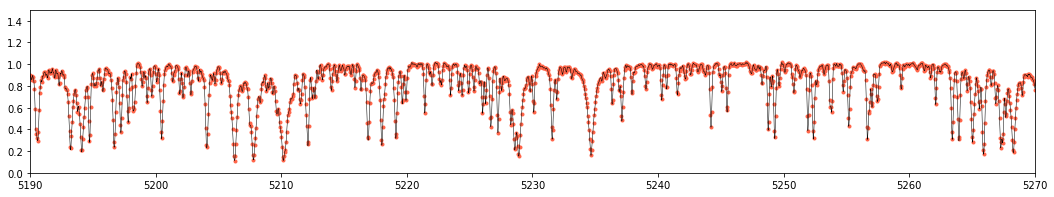

In [10]:
from scipy.interpolate import splrep, BSpline

aaflux = ace_data[5,9,:]
aawave = ace_data[0,9,:]

tt, cc, kk = splrep(aawave, aaflux, k=3)
f  = BSpline(tt, cc, kk, extrapolate=False)
xx = np.linspace(3500, 7000, 300000)
yy = f(xx)

fig, ax = plt.subplots(figsize=[18,3])
ax.plot(aawave, aaflux, '.')
ax.plot(xx, yy, '-', c='k', lw=.5)
ax.set_xlim(5190, 5270)
ax.set_ylim(0, 1.5)


eeflux = eps_data[5,9,:]
eewave = eps_data[0,9,:]

tt, cc, kk = splrep(eewave, eeflux, k=3)
f  = BSpline(tt, cc, kk, extrapolate=False)
xx = np.linspace(3500, 7000, 300000)
yy = f(xx)

fig, ax = plt.subplots(figsize=[18,3])
ax.plot(eewave, eeflux, '.', c='tomato')
ax.plot(xx, yy, '-', c='k', lw=.5)
ax.set_xlim(5190, 5270)
ax.set_ylim(0, 1.5)

Para los ordenes superpuestos se ve que el spline da "saltos" raros entre puntos de distintos ordenes

(0, 1.5)

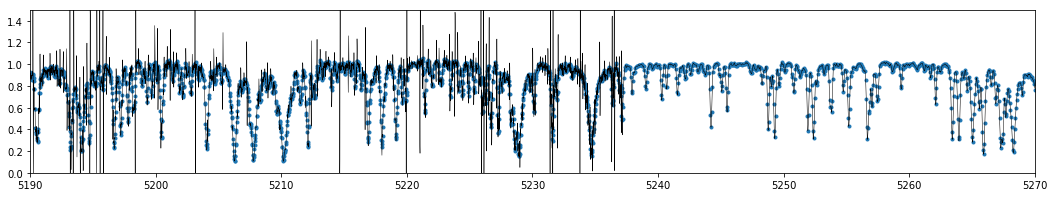

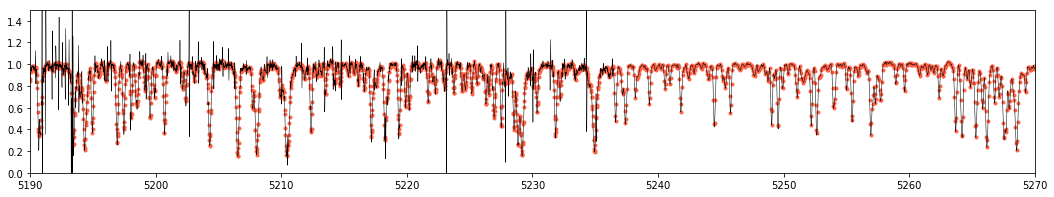

In [11]:
from scipy.interpolate import splrep, BSpline

#eord = np.argsort(ewave)

#tt, cc, kk = splrep(ewave[eord], eflux[eord], k=3)
tt, cc, kk = splrep(ewave, eflux, k=3)
f  = BSpline(tt, cc, kk, extrapolate=False)
xx = np.linspace(3500, 7000, 300000)
yy = f(xx)

fig, ax = plt.subplots(figsize=[18,3])
ax.plot(ewave, eflux, '.')
ax.plot(xx, yy, '-', c='k', lw=.5)
ax.set_xlim(5190, 5270)
#ax.set_xlim(6004, 6008)
ax.set_ylim(0, 1.5)



tt, cc, kk = splrep(awave, aflux, k=3)
f  = BSpline(tt, cc, kk, extrapolate=False)
xx = np.linspace(3500, 7000, 300000)
yy = f(xx)

fig, ax = plt.subplots(figsize=[18,3])
ax.plot(awave, aflux, '.', c='tomato')
ax.plot(xx, yy, '-', c='k', lw=.5)
ax.set_xlim(5190, 5270)
#ax.set_xlim(6004, 6008)
ax.set_ylim(0, 1.5)

Al final, debiera darse una correlación entre estos indicadores (sobre todo el primero) con el índice S en presencia de actividad. Aquí se debería poder medir la pendiente de esta correlación (se ve que es más menos una recta) y además se calcula el coeficiente de correlación de Kendall ($\tau$).

Un test adicional (que ellos hacen) sería encontrar la periodicidad del core flux de las líneas seleccionadas, pues muestran una sinusoide bien clara (Figura 8 de Wise et al) recuperable con un GLS.